In [1]:
!pip install apafib --upgrade --quiet

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

In [3]:
import pandas as pd
from pandas import read_csv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB

from sklearn.model_selection import GridSearchCV

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier import precision_recall_curve

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

# **Problema individual 3: ¿Que trae a los Franceses a Barcelona?**

Francia es un país vecino, y obviamente esa vecindad hace que muchos vengan a visitar Barcelona, pero ¿cuántos vendrán?. El ayuntamiento de Barcelona recolecta diversos datos sobre la ciudad en su portal de datos abiertos. Vamos a trabajar con un extracto de esos datos para los años 2021-2023 con un subconjunto de variables que hemos elegido según nuestro criterio experto que incluyen alimentos, datos meteorológicos y llegadas al aeropuerto. El objetivo es aproximar el número de visitantes diarios de ciudadanos Franceses a Barcelona.

### Lectura inicial de datos

In [5]:
from apafib import load_BCN_Francia
FR_data = load_BCN_Francia()

FR_data.head()

,Carnes-Llenguado,Carnes-Llobarro,Carnes-Lluç,Carnes-Orada,Carnes-Pollastre,Carnes-Porcí,Frutas-Ceba,Frutas-Patata,Frutas-Plàtan,Frutas-Poma,Frutas-Taronja,Temperatura-Barcelona - el Raval,Temperatura-Barcelona - Observatori Fabra,Temperatura-Barcelona - Zona Universitària,Precipitacion-Barcelona - el Raval,Precipitacion-Barcelona - Observatori Fabra,Precipitacion-Barcelona - Zona Universitària,AeronavesPrat-Aeronaves,VisitantesPais-França
Dia,,,,,,,,,,,,,,,,,,,
2021-07-21,14.0,4.8,7.5,4.4,1.110,1.360,0.25,0.41,1.8,0.800,0.8,27.74,26.46,27.38,0.0,0.0,0.0,581.0,21751.0
2021-07-22,14.0,4.8,7.0,4.4,1.094,1.354,0.25,0.41,1.8,0.800,0.8,28.67,27.93,27.81,0.0,0.0,0.0,644.0,23777.0
2021-07-23,14.0,4.8,6.5,4.4,1.079,1.349,0.25,0.41,1.8,0.800,0.8,28.62,27.52,27.64,0.0,0.0,0.0,723.0,26755.0
2021-07-24,14.0,4.8,6.5,4.4,1.063,1.343,0.25,0.41,1.8,0.833,0.8,26.32,25.53,26.22,0.0,0.0,0.0,625.0,29754.0
2021-07-25,14.0,4.8,6.5,4.4,1.047,1.337,0.25,0.41,1.8,0.867,0.8,26.00,24.18,26.06,0.0,0.0,0.0,690.0,27309.0


In [6]:
# Columna de visitantes es la variable respuesta. Reordenamos para ponerla en primer lugar

cols = list(FR_data.columns)
cols.remove('VisitantesPais-França')
cols.insert(0, 'VisitantesPais-França')
FR_data = FR_data.reindex(columns=cols)

FR_data.head()

,VisitantesPais-França,Carnes-Llenguado,Carnes-Llobarro,Carnes-Lluç,Carnes-Orada,Carnes-Pollastre,Carnes-Porcí,Frutas-Ceba,Frutas-Patata,Frutas-Plàtan,Frutas-Poma,Frutas-Taronja,Temperatura-Barcelona - el Raval,Temperatura-Barcelona - Observatori Fabra,Temperatura-Barcelona - Zona Universitària,Precipitacion-Barcelona - el Raval,Precipitacion-Barcelona - Observatori Fabra,Precipitacion-Barcelona - Zona Universitària,AeronavesPrat-Aeronaves
Dia,,,,,,,,,,,,,,,,,,,
2021-07-21,21751.0,14.0,4.8,7.5,4.4,1.110,1.360,0.25,0.41,1.8,0.800,0.8,27.74,26.46,27.38,0.0,0.0,0.0,581.0
2021-07-22,23777.0,14.0,4.8,7.0,4.4,1.094,1.354,0.25,0.41,1.8,0.800,0.8,28.67,27.93,27.81,0.0,0.0,0.0,644.0
2021-07-23,26755.0,14.0,4.8,6.5,4.4,1.079,1.349,0.25,0.41,1.8,0.800,0.8,28.62,27.52,27.64,0.0,0.0,0.0,723.0
2021-07-24,29754.0,14.0,4.8,6.5,4.4,1.063,1.343,0.25,0.41,1.8,0.833,0.8,26.32,25.53,26.22,0.0,0.0,0.0,625.0
2021-07-25,27309.0,14.0,4.8,6.5,4.4,1.047,1.337,0.25,0.41,1.8,0.867,0.8,26.00,24.18,26.06,0.0,0.0,0.0,690.0


## Apartado A:

Divide el conjunto de datos en entrenamiento y test (80 %/20 %). Haz una exploración mínima del conjunto de datos de entrenamiento observando las relaciones entre las variables especialmente con la variable objetivo. Describe las cosas que hayas visto que te parezcan
interesantes. A veces tener información basada en la fecha puede ayudar en la predicción. 

El índice de los datos es la fecha, obtén a partir de ella el día, el día de la semana y el mes y añádelos a la matriz de datos. Normaliza las variables adecuadamente para poder ajustar un modelo de regresión tanto para el conjunto de entrenamiento como para el de test. 
El valor a predecir tiene una magnitud bastante grande (decenas de miles). Esto hace difícil a veces el obtener una buena predicción con algunos modelos, ya que los pesos necesarios para obtener la salida son muy grandes. Una transformación común es transformar la variable respuesta aplicando el logaritmo.

Realizaré el split más tarde porque me facilitará la exploración, análisis y preprocesado.

### Análisis exploratorio de los datos

In [7]:
print(f"Número de columnas (features): {FR_data.shape[1]}")
FR_data.describe(include='all').T
FR_data.info()

Número de columnas (features): 19


,count,mean,std,min,25%,50%,75%,max
VisitantesPais-França,725.0,30994.616,15206.516,6518.00,20894.000,27615.000,38478.000,96196.00
Carnes-Llenguado,725.0,17.584,2.830,12.80,15.000,18.000,19.000,29.00
Carnes-Llobarro,725.0,5.879,0.519,4.80,5.500,5.800,6.300,6.85
Carnes-Lluç,725.0,4.680,0.811,2.50,4.000,4.667,5.200,7.50
Carnes-Orada,725.0,4.885,0.404,4.20,4.500,4.867,5.200,5.80
Carnes-Pollastre,725.0,1.279,0.185,0.87,1.154,1.304,1.420,1.52
Carnes-Porcí,725.0,1.536,0.339,1.02,1.221,1.644,1.720,2.02
Frutas-Ceba,725.0,0.566,0.283,0.22,0.270,0.520,0.800,1.25
Frutas-Patata,725.0,0.575,0.144,0.35,0.450,0.600,0.650,0.85
Frutas-Plàtan,725.0,1.760,0.576,1.00,1.267,1.700,2.000,3.20


<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, 2021-07-21 to 2023-07-15
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   VisitantesPais-França                         725 non-null    float64
 1   Carnes-Llenguado                              725 non-null    float64
 2   Carnes-Llobarro                               725 non-null    float64
 3   Carnes-Lluç                                   725 non-null    float64
 4   Carnes-Orada                                  725 non-null    float64
 5   Carnes-Pollastre                              725 non-null    float64
 6   Carnes-Porcí                                  725 non-null    float64
 7   Frutas-Ceba                                   725 non-null    float64
 8   Frutas-Patata                                 725 non-null    float64
 9   Frutas-Plàtan                                 725 non-

No tenemos ninguna variable categórica, así que no hará falta recodificar las variables.

Además, no vemos missing values, por ende no debemos borrar filas ni añadirlos artificialmente.

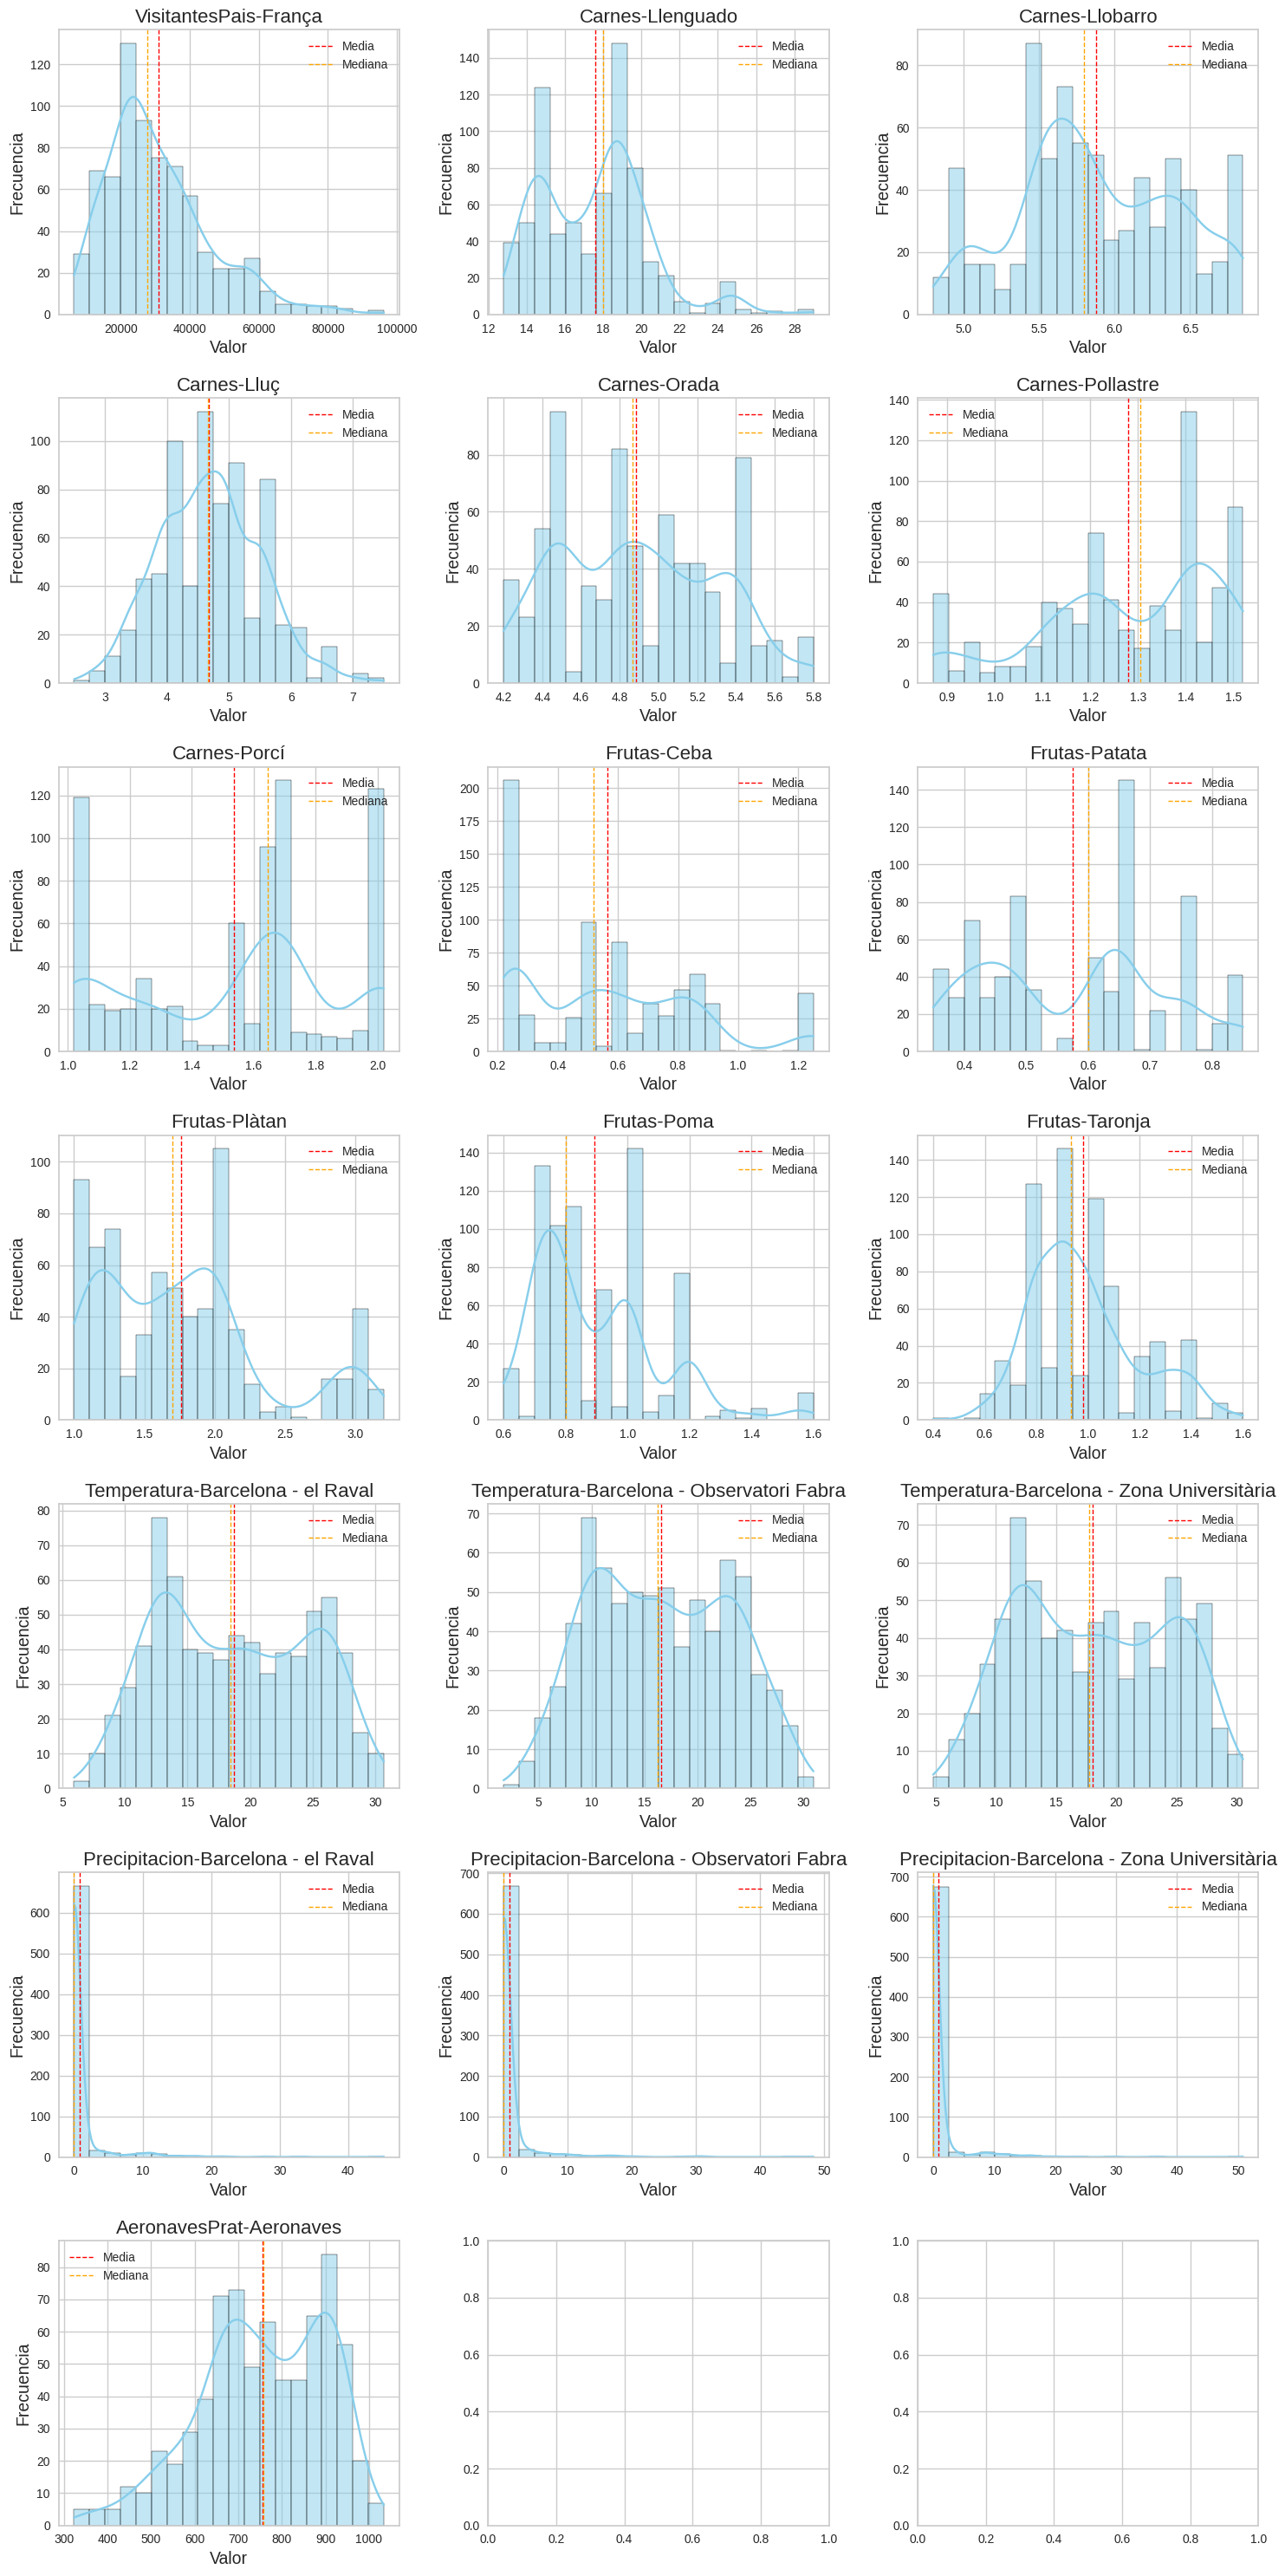

In [8]:
fig, axes = plt.subplots(7,3,figsize=(15,30))

for i, c in enumerate(FR_data.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=FR_data, x=c, ax=ax, bins=20, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = FR_data[c].mean()
    median = FR_data[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

Analicemos que observamos de los datos. Lo haremos por partes según los subconjuntos que se presentan.

* Vemos una gran disparidad de resultados en lo que respecta a carnes, con una curiosa pseudo-gaussinidad en el Lluç.
* Las frutas más de lo mismo, no presentan resultados comparables entre ellas.
* Las temperaturas así cómo la precipitación son muy similares entre ellas, pero es algo de esperar ya que estamos trabajando sobre una sola ciudad.
* Por último, no tenemos algo con lo que comparar las aeronaves, pero podría ser una de las variables más interesantes cuando la pongamos con la variable objetivo.

Vayamos a algo más interesante, la correlación con estas variables entre ellas y la objetivo:

<Figure size 3000x1600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlación entre variables')

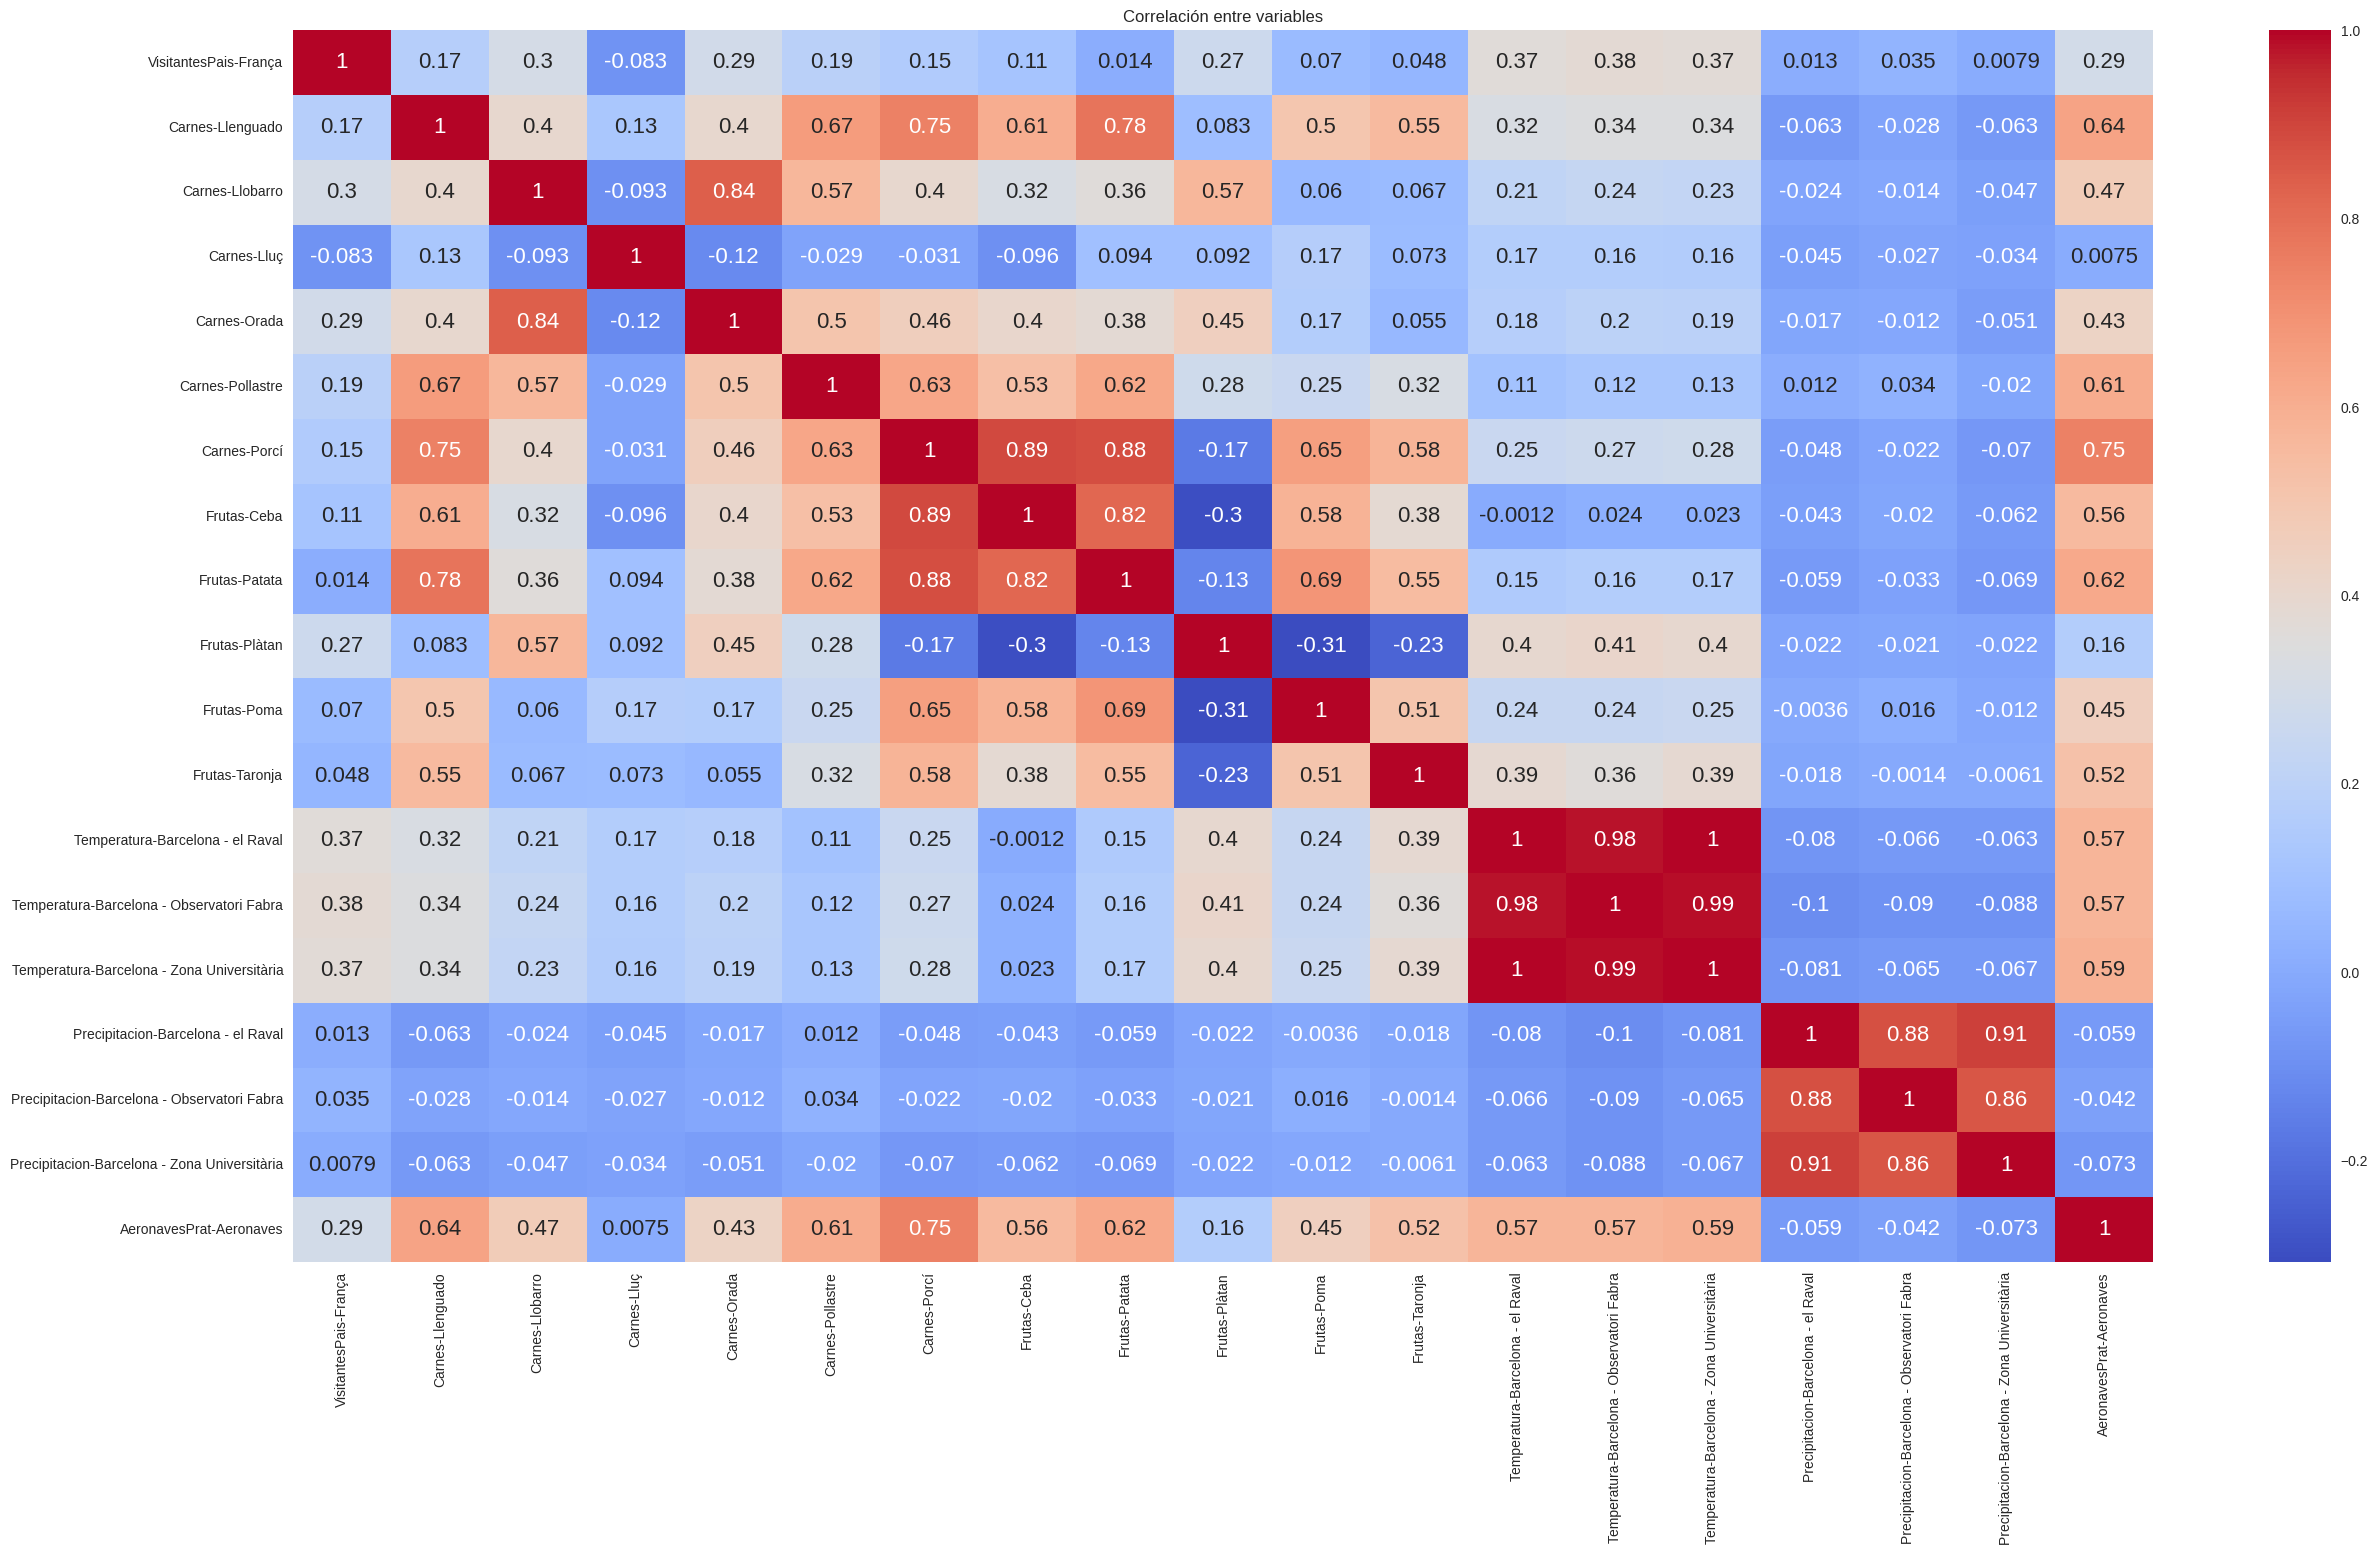

In [9]:
plt.figure(figsize=(30, 16))
sns.heatmap(FR_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables')
plt.show()

Empezaremos por la correlación con respecto al número de visitantes, que es la que nos interesa.

Ninguna de las variables tiene una correlación igual o superior al 0.4, las que más se acercan son las temperaturas. Podemos asumir que esto se debe a las vacaciones de verano que deben realizar los turistas, pero no hay una correlación suficiente para indicar este como el factor fundamental. Lo mismo vemos con el resto de variables, donde las más destacables son el Llobarro, la Orada (en carnes), el plátano y las aeronaves. Así a primera vista, no podríamos destacar algo que nos permita definir cuando y/o por qué vienen.

Las carnes y frutas parecen presentar correlaciones altas y bajas a partes iguales, a veces entre elementos del mismo fruto y en otras carnes con frutas, sorprendentemente.

Como es de esperar, las temperaturas y precipitaciones tienen correlaciones altas únicamente entre ellas, exceptuando un caso curioso: las temperaturas con el número de aeronaves.

Añadimos ahora las columnas extra. Nos permitirán observar si en ciertos días, fines de semana o meses hay más turistas que en otros.

In [10]:
FR_data_d = FR_data.copy()

# no convertimos a dateTime el índice porque da problemas en la visualización de datos, usamos una variable aparte
indice = pd.to_datetime(FR_data_d.index)

# Extraer características temporales

FR_data_d['dia'] = indice.day
FR_data_d['dia_semana'] = indice.weekday  # 0 = lunes, 6 = domingo
FR_data_d['mes'] = indice.month

cols = list(FR_data_d.columns)
cols.remove('VisitantesPais-França')
cols.insert(0, 'VisitantesPais-França')
FR_data_d = FR_data_d.reindex(columns=cols)
FR_data_d.head()

,VisitantesPais-França,Carnes-Llenguado,Carnes-Llobarro,Carnes-Lluç,Carnes-Orada,Carnes-Pollastre,Carnes-Porcí,Frutas-Ceba,Frutas-Patata,Frutas-Plàtan,...,Temperatura-Barcelona - el Raval,Temperatura-Barcelona - Observatori Fabra,Temperatura-Barcelona - Zona Universitària,Precipitacion-Barcelona - el Raval,Precipitacion-Barcelona - Observatori Fabra,Precipitacion-Barcelona - Zona Universitària,AeronavesPrat-Aeronaves,dia,dia_semana,mes
Dia,,,,,,,,,,,,,,,,,,,,,
2021-07-21,21751.0,14.0,4.8,7.5,4.4,1.110,1.360,0.25,0.41,1.8,...,27.74,26.46,27.38,0.0,0.0,0.0,581.0,21,2,7
2021-07-22,23777.0,14.0,4.8,7.0,4.4,1.094,1.354,0.25,0.41,1.8,...,28.67,27.93,27.81,0.0,0.0,0.0,644.0,22,3,7
2021-07-23,26755.0,14.0,4.8,6.5,4.4,1.079,1.349,0.25,0.41,1.8,...,28.62,27.52,27.64,0.0,0.0,0.0,723.0,23,4,7
2021-07-24,29754.0,14.0,4.8,6.5,4.4,1.063,1.343,0.25,0.41,1.8,...,26.32,25.53,26.22,0.0,0.0,0.0,625.0,24,5,7
2021-07-25,27309.0,14.0,4.8,6.5,4.4,1.047,1.337,0.25,0.41,1.8,...,26.00,24.18,26.06,0.0,0.0,0.0,690.0,25,6,7


Text(0.5, 1.0, 'Evolución de visitantes en función del tiempo')

Text(0.5, 0, 'Fecha')

Text(0, 0.5, 'Número')

[Text(0.0, 0, '2021-07-21'),
 Text(10.0, 0, '2021-07-31'),
 Text(20.0, 0, '2021-08-10'),
 Text(30.0, 0, '2021-08-20'),
 Text(40.0, 0, '2021-08-30'),
 Text(50.0, 0, '2021-09-09'),
 Text(60.0, 0, '2021-09-19'),
 Text(70.0, 0, '2021-09-29'),
 Text(80.0, 0, '2021-10-09'),
 Text(90.0, 0, '2021-10-19'),
 Text(100.0, 0, '2021-10-29'),
 Text(110.0, 0, '2021-11-08'),
 Text(120.0, 0, '2021-11-18'),
 Text(130.0, 0, '2021-11-28'),
 Text(140.0, 0, '2021-12-08'),
 Text(150.0, 0, '2021-12-18'),
 Text(160.0, 0, '2021-12-28'),
 Text(170.0, 0, '2022-01-07'),
 Text(180.0, 0, '2022-01-17'),
 Text(190.0, 0, '2022-01-27'),
 Text(200.0, 0, '2022-02-06'),
 Text(210.0, 0, '2022-02-16'),
 Text(220.0, 0, '2022-02-26'),
 Text(230.0, 0, '2022-03-08'),
 Text(240.0, 0, '2022-03-18'),
 Text(250.0, 0, '2022-03-28'),
 Text(260.0, 0, '2022-04-07'),
 Text(270.0, 0, '2022-04-17'),
 Text(280.0, 0, '2022-04-27'),
 Text(290.0, 0, '2022-05-07'),
 Text(300.0, 0, '2022-05-17'),
 Text(310.0, 0, '2022-05-27'),
 Text(320.0, 0, '20

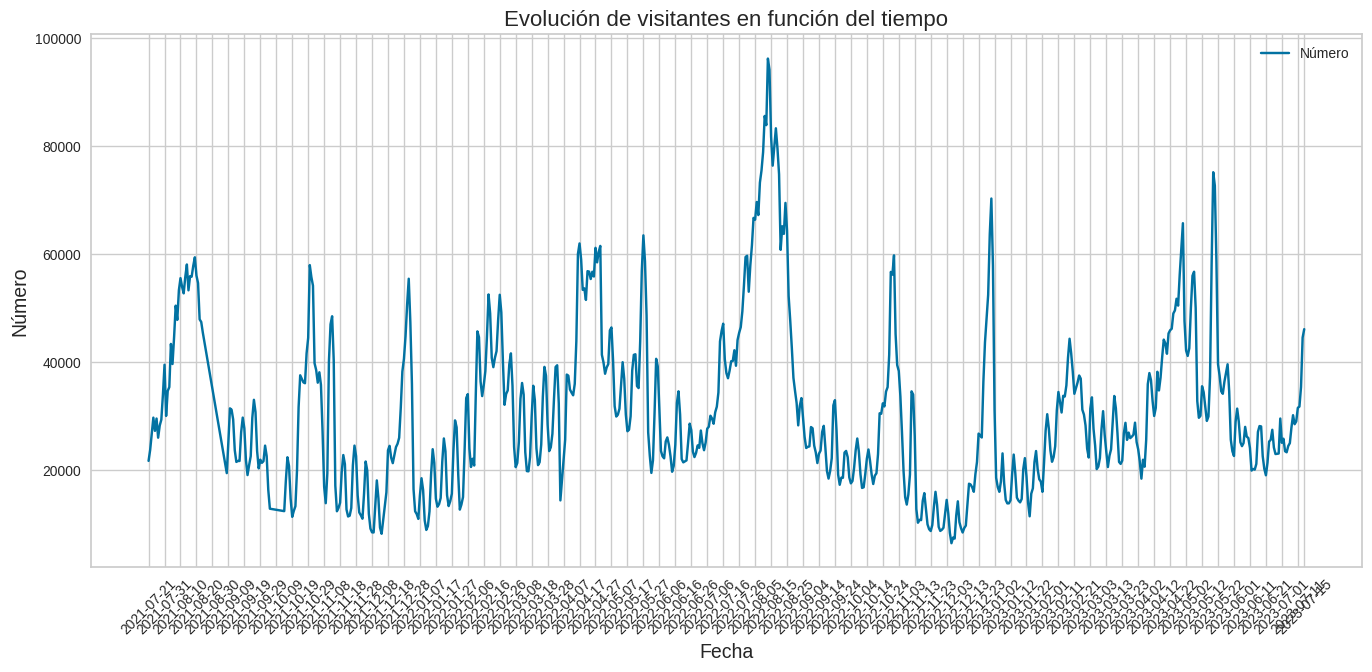

In [11]:
dates = FR_data.index

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(dates, FR_data['VisitantesPais-França'], label='Número')
        
ax.set_title('Evolución de visitantes en función del tiempo', fontsize=16)
ax.set_xlabel('Fecha', fontsize=14)
ax.set_ylabel('Número', fontsize=14)    
ax.legend()

# Mostramos una etiqueta cada 10 valores
ax.set_xticks(list(dates[::10]) + [dates[-1]])
ax.set_xticklabels(list(dates[::10]) + [dates[-1]], rotation=45)

plt.tight_layout()
plt.show()

Si bien es cierto que es inviable mostrar todas las fechas, podemos ver con un intervalo de 10 valores que la mayoría de picos de visitantes suceden durante épocas de vacaciones. En especial agosto y diciembre. Vemos también ciertos menores pero también destacables en épocas como octubre y alguno entre abril y mayo. El mayor pico de todos, con diferencia, se encuentra en agosto de 2022.

No es extraño que este sea el caso si consideramos que fue el primer verano en que casi, sino todas las restricciones debidas al Covid fueron eliminadas y se permitía libertad de vacaciones.

Hacemos ahora el split de datos. Si bien son datos ordenados temporalmente, se ha observado que esto NO es un factor relevante en lo que respecta a visitas año tras año. Es más importante observar si ciertos meses o semanas tienen más visitas/turismo que otros. Por ende, la validación cruzada es efectiva.

In [12]:
X= FR_data_d.iloc[:,1:]
y= FR_data_d.loc[:,'VisitantesPais-França']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

Por último, realizaremos dos transformaciones a los datos. Normalizaremos X_train y X_test mediante StandardScaler (aunque presuma gaussinidad, converge más rápido y he podido observar mejores resultados) y posteriormente transformaremos la variable objetivo mediante logaritmos.

In [13]:
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()
X_train_n = stdSc.fit_transform(X_train)
X_test_n = stdSc.transform(X_test)

X_train_n = pd.DataFrame(X_train_n, columns=X_train.columns, index=X_train.index)
X_test_n = pd.DataFrame(X_test_n, columns=X_test.columns, index=X_test.index)

# Uso log1p para evitar log(0) (caso improbable, pero por seguridad)
y_train_n = np.log1p(y_train)
y_test_n = np.log1p(y_test)

Volvemos a mostrar los datos para confirmar que en X_train las distribuciones se han mantenido correctamente dentro de los rangos de valores establecidos..

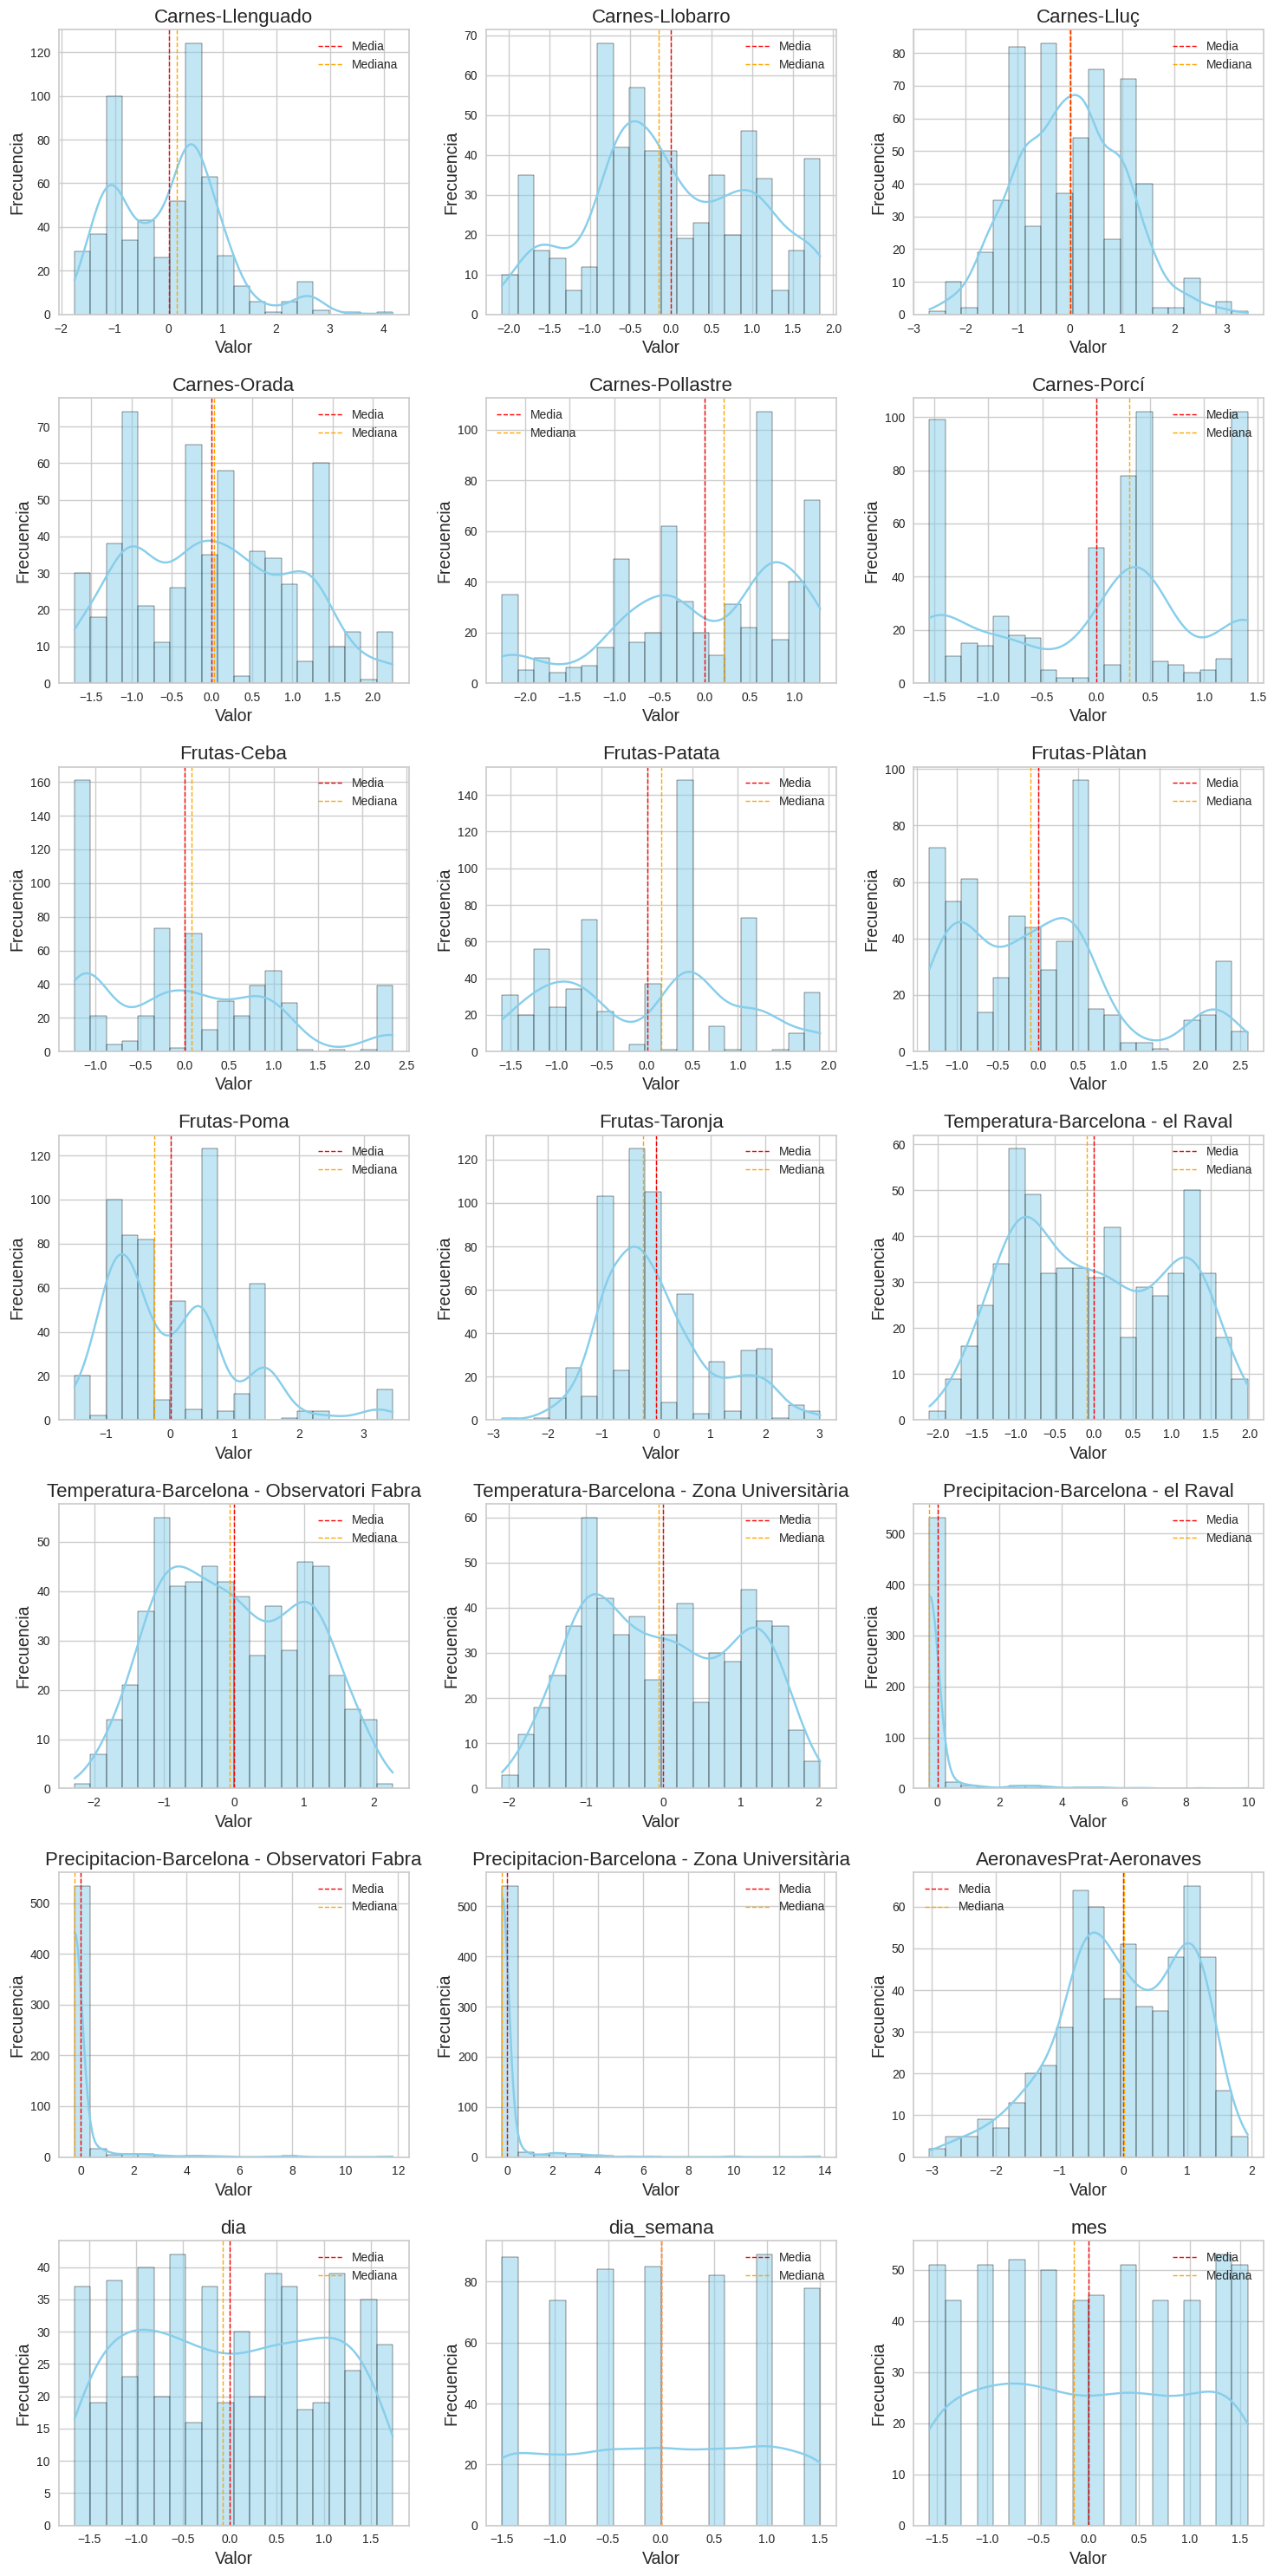

In [14]:
fig, axes = plt.subplots(7,3,figsize=(15,30))

for i, c in enumerate(X_train_n.columns):
    ax = axes.flatten()[i]
    sns.histplot(data=X_train_n, x=c, ax=ax, bins=20, kde=True, color='skyblue')
    ax.set_title(c, fontsize=16)
    ax.set_xlabel('Valor', fontsize=14)
    ax.set_ylabel('Frecuencia', fontsize=14)

    mean = X_train_n[c].mean()
    median = X_train_n[c].median()
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
    ax.axvline(median, color='orange', linestyle='dashed', linewidth=1, label='Mediana')
    ax.legend()

plt.tight_layout();
plt.show();

Las proporciones se mantienen correctamente. Hecho esto pasamos al segundo apartado.

## Apartado B
Aplica Análisis de Componentes Principales (PCA) al conjunto de entrenamiento y visualízalo en 2D representando la variable objetivo. ¿Crees que puede haber una relación entre las variables del conjunto de datos y la variable objetivo?

<Axes: xlabel='PCA1', ylabel='PCA2'>

Text(0.5, 1.0, 'Distribución PCA separada por mes')

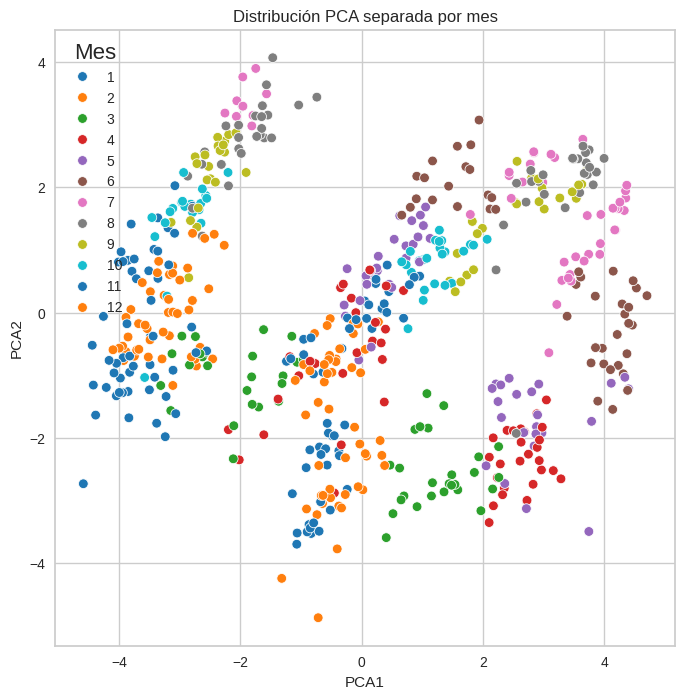

In [15]:
from sklearn.decomposition import PCA

pca = PCA()

interm = pd.to_datetime(X_train_n.index)
mes = interm.map(lambda x: x.month)

tdata = pca.fit_transform(np.asarray(X_train_n))

dfdata = pd.concat([pd.DataFrame(tdata[:, :2], columns=['PCA1', 'PCA2']), 
                    pd.DataFrame({'Mes': mes})], axis=1)

fig = plt.figure(figsize=(8, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Mes', data=dfdata, palette='tab10')
plt.title('Distribución PCA separada por mes')
plt.legend(title='Mes')
plt.show()

He decidido mostrar labels para los meses ya que parece interesante observar agrupaciones de estos.

Observamos tres grupos diferenciados en los datos. En la esquina izquierda, centro y esquina derecha,

Vemos que en los meses hay ciertas distinciones entre ellos. Estas se pueden encontrar en los dos clusters grandes y especialmente el tercero presenta mayores distinciones.

Vemos que ciertos meses presentan menos distinción entre ellas que otros, como son julio, agosto y setiembre (vease el grupo de puntos en el cluster central), pero esto nos puede indicar que por las mismas razones reciben más/menos viajeros que en otros, lo cual nos puede indicar correlación.

En conclusión podemos decir que sí, hay relación entre datos y variable objetivo.

### Apartado C
Para tener un valor base primero ajusta una regresión Ridge a los datos. ¿Te parece suficientemente bueno el resultado? Representa los valores de la variable objetivo para el conjunto de test contra las predicciones y calcula los residuos de la predicción.

In [16]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

lambdas = [1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100] # Lista de valores a usar para determinar la mejor alpha

ridge_cv = RidgeCV(alphas=lambdas,cv=5).fit(X_train_n,y_train_n) # 5 folds ya parecen llegar al mejor resultado

print(f'Best lambda: {ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best lambda: 10.0 R2 score: 0.401


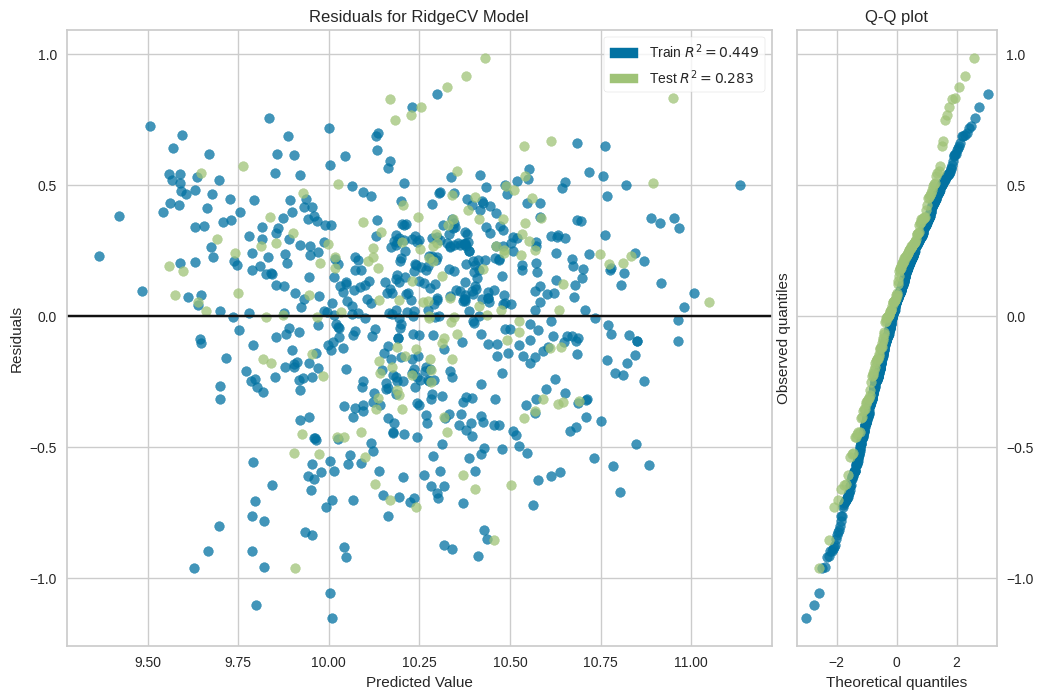

In [17]:
from yellowbrick.regressor import residuals_plot

plt.figure(figsize=(12,8));
viz = residuals_plot(ridge_cv, X_train_n, y_train_n, X_test_n, y_test_n, is_fitted=True, qqplot=True, hist=False);

Vemos unos resultados bastante mejorables. Menos de 0.3 de variancia explicada no es un buen modelo, tenemos aún más de un 70% de la variabilidad sin explicar. Si bien el R² de entrenamiento es superior (la diferencia no es suficiente para sugerir overfitting con datos de entrenamiento), tampoco ha conseguido buenos resultados.

Los cuantiles en términos generales se acercan a los de entrenamiento pero para valores más extremos se alejan de la normalidad, lo cual nos indica que los residuos son asimétricos.

¿Por qué se puede deber esto? Considero factible la posibilidad de que nos encontremos con un modelo con, en su mayoría, relaciones no lineales que Ridge no es capaz de captar. 

## Apartado D
Las redes neuronales nos permiten obtener combinaciones no lineales de los datos que podrían capturar las interacciones entre las variables. Ajusta ahora un MLP explorando sus hiperparámetros adecuadamente. Usa la exploración bayesiana para el ajuste para poder hacer la exploración más eficientemente. Compara los resultados con el modelo anterior usando el MSE.

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV

np.int = int

niter = 15

# Hiperparámetros a usar
param = {'hidden_layer_sizes':[100, 200, 300], 
         'activation':['relu',  'logistic'], 
         'alpha':[0.0001, 0.001, 0.01, 0.1],
         'momentum': [0.95, 0.90, 0.85], 
         'learning_rate_init': [0.001, 0.01, 0.1],
         'n_iter_no_change':[30, 40, 50], 
         'learning_rate': ['constant', 'invscaling', 'adaptive']}

mlp =  MLPRegressor(max_iter=10000,random_state=42)
mlp_bs = BayesSearchCV(mlp,param,n_iter=niter, 
                        cv=cv,
                        scoring="neg_mean_squared_error", # A diferencia de Ridge, aquí no evaluaremos mediante r2
                        n_jobs=-1, 
                        refit=True, random_state=42)    
mlp_bs.fit(X_train_n, y_train_n);

In [19]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
13,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 50}",-0.047,1
4,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 40}",-0.047,2
12,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.1, 'momentum': 0.85, 'n_iter_no_change': 40}",-0.047,2
14,"{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.95, 'n_iter_no_change': 50}",-0.049,4
3,"{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.95, 'n_iter_no_change': 50}",-0.049,5


In [20]:
print('MSE del MLP con Bayes: ', mean_squared_error(y_test_n,mlp_bs.predict(X_test_n)))
print('MSE de la regresión Ridge: ', mean_squared_error(y_test_n,ridge_cv.predict(X_test_n)))

MSE del MLP con Bayes:  0.04234875656111994
MSE de la regresión Ridge:  0.14870351120887468


Observamos que el MSE mediante una red neuronal se ha disminuido a menos de un tercio del modelo base, lo cuál es una mejora sustancial. El MLP es capaz de capturar interacciones no lineales entre variables y por ende realiza un trabajo superior. El ajuste de hiperparámetros, al menos con este dataset, no es costoso y permite un entrenamiento rápido, dejando el modelo Ridge obsoleto.

In [21]:
print('R² del MLP con Bayes: ', r2_score(y_test_n,mlp_bs.predict(X_test_n)))
print('R² de la regresión Ridge: ', r2_score(y_test_n,ridge_cv.predict(X_test_n)))

R² del MLP con Bayes:  0.7958810228879969
R² de la regresión Ridge:  0.2832562024079398


Si bien no era requerido, me parece interesante mostrar la diferencia del R² entre Ridge y el MLP. Este último consigue explicar casi un 80% de la variabilidad a diferencia del 28% del modelo original. Estos resultados ya son bastante buenos, pero veremos si con un modelo con menos features podemos obtener mejores resultados. Es posible que tengamos variables que, en vez de aportar, estén causando overfitting y empeorando nuestro modelo.

## Apartado E

La red neuronal no puede darnos la importancia que tiene cada atributo en la predicción, pero podemos intentar reducir el número de variables que son necesarias para saber si alguna no es relevante. Un algoritmo eficiente de reducción de atributos es hacer una búsqueda avariciosa añadiendo (o eliminado) atributos evaluando el modelo hasta obtener un subconjunto que obtenga el mejor resultado. Tienes una implementación en scikit-learn que utiliza validación cruzada para la evaluación (SequentialFeatureSelector). Para aplicarlo hay que pasarle un modelo ya ajustado, puedes hacer la búsqueda hacia adelante.
Usaremos el modelo MLP del apartado anterior. Tendrás que usar también el MSE como evaluación, Obtén con este método un conjunto de atributos reducido y vuelve a ajustar los hiperparámetros del MLP con estos datos. Compara los resultados.

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(
    mlp,
    n_features_to_select="auto", # Selecciona el número óptimo de features
    scoring="neg_mean_squared_error",
    direction="forward",
    cv=cv,  
    n_jobs=-1 
)

sfs.fit(X_train_n, y_train_n)

SequentialFeatureSelector(estimator=MLPRegressor(max_iter=10000,
                                                 random_state=42),
                          n_jobs=-1, scoring='neg_mean_squared_error')

In [23]:
selected_features = sfs.get_support(indices=True)
selected_columns = X_train_n.columns[selected_features]
print(selected_columns)

Index(['Carnes-Llenguado', 'Carnes-Llobarro', 'Carnes-Lluç', 'Carnes-Orada',
       'Carnes-Pollastre', 'Frutas-Ceba', 'Frutas-Patata', 'Frutas-Taronja',
       'Temperatura-Barcelona - el Raval', 'dia_semana'],
      dtype='object')


Vemos que las variables que se consideran más relevantes son las carnes, ciertas frutas, la temperatura en el Raval (al ser las 3 variables de temperatura tan parecida, una ya es suficiente) y el día de la semana. Es interesante observar que el mes del año no haya sido seleccionado, nos indica esto que el mes no es tan relevante como el día de la semana al determinar cuando vendrán franceses a Barcelona (muy probablemente, durante los fines de semana).

In [24]:
X_train_red = X_train_n[selected_columns]
X_test_red = X_test_n[selected_columns]

# Reentrenar el modelo MLP con las características seleccionadas y los mejores hiperparámetros
mlp_red = MLPRegressor(max_iter=10000, random_state=42, **mlp_bs.best_params_)
mlp_bs_red = BayesSearchCV(mlp_red,param,n_iter=niter, 
                        cv=cv,
                        scoring="neg_mean_squared_error", 
                        n_jobs=-1, 
                        refit=True, random_state=42)  
mlp_bs_red.fit(X_train_red, y_train_n)

BayesSearchCV(cv=5,
              estimator=MLPRegressor(activation='logistic', alpha=0.001,
                                     hidden_layer_sizes=200,
                                     learning_rate='invscaling',
                                     learning_rate_init=0.1, max_iter=10000,
                                     momentum=0.85, n_iter_no_change=50,
                                     random_state=42),
              n_iter=15, n_jobs=-1, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01, 0.1],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
            

In [25]:
print('MSE del MLP reducido con Bayes: ', mean_squared_error(y_test_n,mlp_bs_red.predict(X_test_red)))
print('MSE del MLP con Bayes: ', mean_squared_error(y_test_n,mlp_bs.predict(X_test_n)))
print('MSE de la regresión Ridge: ', mean_squared_error(y_test_n,ridge_cv.predict(X_test_n)))

MSE del MLP reducido con Bayes:  0.038487906994579796
MSE del MLP con Bayes:  0.04234875656111994
MSE de la regresión Ridge:  0.14870351120887468


In [26]:
print('R² del MLP reducido con Bayes: ', r2_score(y_test_n,mlp_bs_red.predict(X_test_red)))
print('R² del MLP con Bayes: ', r2_score(y_test_n,mlp_bs.predict(X_test_n)))
print('R² de la regresión Ridge: ', r2_score(y_test_n,ridge_cv.predict(X_test_n)))

R² del MLP reducido con Bayes:  0.8144901327722058
R² del MLP con Bayes:  0.7958810228879969
R² de la regresión Ridge:  0.2832562024079398


Observamos una mejora ligera en el MSE y R² con menos features, lo cual nos confirma que, si bien ligero, había overfitting por variables irrelevantes.

### Conclusiones finales

Con más de un 81% de varianza explicada, y un MSE bajo, podemos confirmar que esta red neuronal es un buen modelo para determinar con suficiente fiabilidad cuando llegarán más/menos franceses a la ciudad, mediante características como las carnes, frutas y la temperatura en ese momento en Barcelona, así como el día de la semana en que con más probabilidad esto ocurra.

El selector de features es lento, pero al terminar de encontrar los parámetros, mediante un MLP ya entrenado, es muy sencillo extraer los mejores hiperparámetros y crear un nuevo modelo modificado con únicamente features verdaderamente relevantes. El entrenamiento no ha sido demasiado costoso temporalmente como para considerar el MLP original una mejor opción.